### correct abstract

                   Metric  Accuracy  Total Count
          Answer Accuracy  0.916090         8533
     Discrepancy Accuracy  0.666120         8533
Evidence Quality Accuracy  0.820462         8533


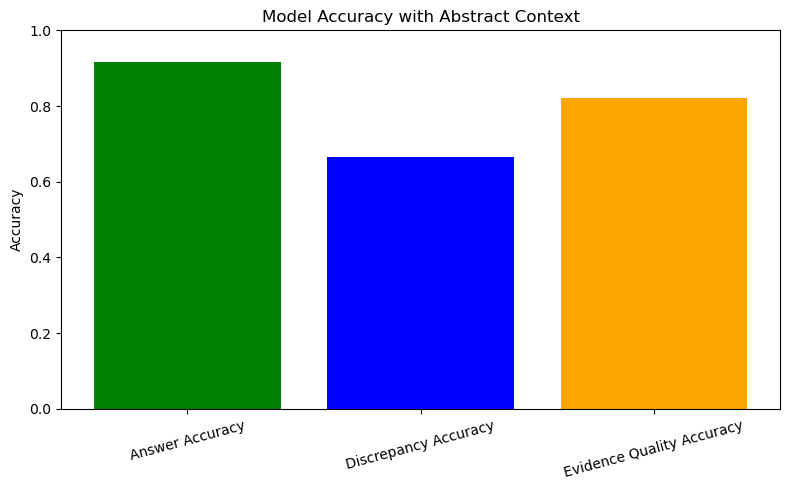

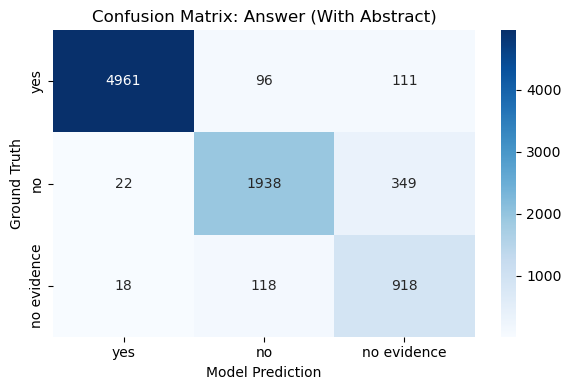

In [3]:
import json
import pandas as pd

# Load RAG result JSON
with open("rag_eval_results_with_abstract.json", "r") as f:
    with_abstract = json.load(f)

# Convert to DataFrame
df_with_abstract = pd.DataFrame.from_dict(with_abstract, orient="index")


import matplotlib.pyplot as plt
import pandas as pd

# Normalize string fields
df_with_abstract["model_answer"] = df_with_abstract["model_answer"].str.lower().str.strip()
df_with_abstract["ground_truth_answer"] = df_with_abstract["ground_truth_answer"].str.lower().str.strip()
df_with_abstract["model_discrepancy"] = df_with_abstract["model_discrepancy"].str.lower().str.strip()
df_with_abstract["ground_truth_discrepancy"] = df_with_abstract["ground_truth_discrepancy"].str.lower().str.strip()
df_with_abstract["model_evidence-quality"] = df_with_abstract["model_evidence-quality"].str.lower().str.strip()
df_with_abstract["ground_truth_evidence-quality"] = df_with_abstract["ground_truth_evidence-quality"].str.lower().str.strip()

# Compute correctness flags
df_with_abstract["answer_correct"] = df_with_abstract["model_answer"] == df_with_abstract["ground_truth_answer"]
df_with_abstract["discrepancy_correct"] = df_with_abstract["model_discrepancy"] == df_with_abstract["ground_truth_discrepancy"]
df_with_abstract["evidence_quality_correct"] = df_with_abstract["model_evidence-quality"] == df_with_abstract["ground_truth_evidence-quality"]

# Summary DataFrame
summary_df = pd.DataFrame({
    "Metric": ["Answer Accuracy", "Discrepancy Accuracy", "Evidence Quality Accuracy"],
    "Accuracy": [
        df_with_abstract["answer_correct"].mean(),
        df_with_abstract["discrepancy_correct"].mean(),
        df_with_abstract["evidence_quality_correct"].mean()
    ],
    "Total Count": len(df_with_abstract)
})

# Display summary
print(summary_df.to_string(index=False))

# Bar chart
plt.figure(figsize=(8, 5))
plt.bar(summary_df["Metric"], summary_df["Accuracy"], color=["green", "blue", "orange"])
plt.ylim(0, 1)
plt.title("Model Accuracy with Abstract Context")
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()






import seaborn as sns
from sklearn.metrics import confusion_matrix

# Normalize answer fields
df_with_abstract["model_answer"] = df_with_abstract["model_answer"].str.lower().str.strip()
df_with_abstract["ground_truth_answer"] = df_with_abstract["ground_truth_answer"].str.lower().str.strip()

# Define labels for consistency
labels = ["yes", "no", "no evidence"]

# Generate confusion matrix
cm = confusion_matrix(
    df_with_abstract["ground_truth_answer"],
    df_with_abstract["model_answer"],
    labels=labels
)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: Answer (With Abstract)")
plt.xlabel("Model Prediction")
plt.ylabel("Ground Truth")
plt.tight_layout()
plt.show()


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# === Load data ===
with open("test_4o_mini_on_4o_questions_with_predictions.json", "r") as f:
    no_context = json.load(f)

with open("rag_eval_results_with_abstract.json", "r") as f:
    with_abstract = json.load(f)

# === Convert to DataFrames ===
def build_df(source):
    records = []
    for qid, item in source.items():
        records.append({
            "qid": qid,
            "doi": item.get("doi", "").strip().lower(),
            "question": item.get("question", "").strip(),
            "model_answer": item.get("model_answer", "").strip().lower(),
            "ground_truth_answer": item.get("ground_truth_answer", "").strip().lower(),
        })
    return pd.DataFrame(records)

df_no = build_df(no_context)
df_abs = build_df(with_abstract)

# === Merge on QID and DOI ===
df_merged = pd.merge(df_no, df_abs, on=["qid", "doi"], suffixes=("_no", "_abs"))

# === Correctness Flags ===
df_merged["correct_no"] = df_merged["model_answer_no"] == df_merged["ground_truth_answer_no"]
df_merged["correct_abs"] = df_merged["model_answer_abs"] == df_merged["ground_truth_answer_no"]

# === Subsets ===
df_incorrect = df_merged[~df_merged["correct_no"]]
df_correct = df_merged[df_merged["correct_no"]]

# === Counts and Accuracy ===
n_total = len(df_merged)
n_correct_no = df_merged["correct_no"].sum()
n_correct_abs = df_merged["correct_abs"].sum()

n_incorrect = len(df_incorrect)
n_fixed = df_incorrect["correct_abs"].sum()

n_correct = len(df_correct)
n_still_correct = df_correct["correct_abs"].sum()

# === Accuracy values ===
acc_original = n_correct_no / n_total
acc_after = n_correct_abs / n_total

acc_fixed = n_fixed / n_incorrect if n_incorrect > 0 else 0
acc_retained = n_still_correct / n_correct if n_correct > 0 else 0

# === Plotting helper ===
def plot_pair(title, labels, heights, counts, colors):
    plt.figure(figsize=(4.5, 4))
    bars = plt.bar(labels, heights, color=colors)

    for bar, count, total, acc in zip(bars, counts, [n_incorrect, n_incorrect] if "Incorrect" in title else [n_correct, n_correct] if "Correct" in title else [n_total, n_total], heights):
        label = f"{count}/{total} = {acc:.2%}"
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, label, ha='center', fontsize=11)

    plt.ylim(0, 1.1)
    plt.ylabel("Accuracy")
    plt.xticks(rotation=0)
    plt.subplots_adjust(bottom=0.25)  # leave space for title
    plt.xlabel(title, fontsize=12)
    plt.tight_layout()
    plt.show()




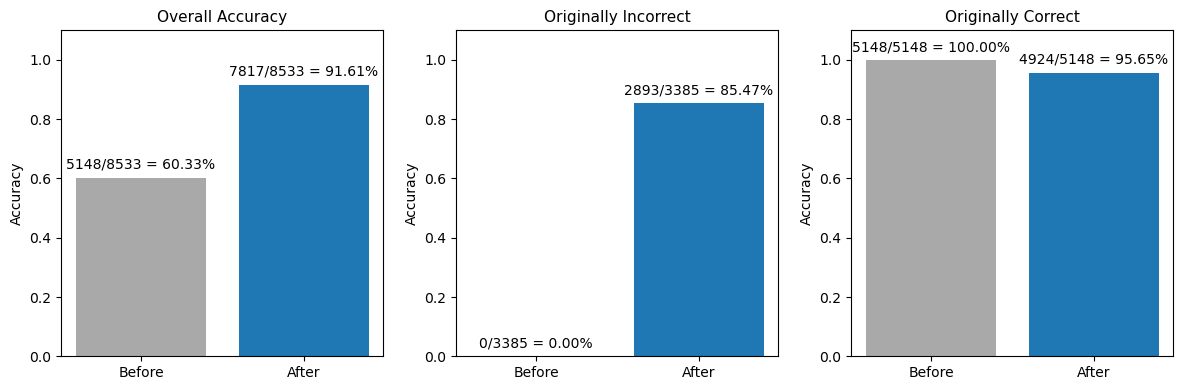

In [2]:
import matplotlib.pyplot as plt

def plot_pair(ax, title, labels, heights, counts, totals, colors):
    bars = ax.bar(labels, heights, color=colors)
    for bar, count, total, acc in zip(bars, counts, totals, heights):
        label = f"{count}/{total} = {acc:.2%}"
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                label, ha='center', va='bottom', fontsize=10)
    ax.set_ylim(0, 1.1)
    ax.set_title(title, fontsize=11)
    ax.set_ylabel("Accuracy")
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)

# === Color scheme ===
before_color = "#A9A9A9"   # gray
after_color = "#1f77b4"    # blue
colors = [before_color, after_color]

# === Create figure with 3 subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot 1: Overall Accuracy (moved to front)
plot_pair(
    ax=axes[0],
    title="Overall Accuracy",
    labels=["Before", "After"],
    heights=[acc_original, acc_after],
    counts=[n_correct_no, n_correct_abs],
    totals=[n_total, n_total],
    colors=colors
)

# Plot 2: Originally Incorrect
plot_pair(
    ax=axes[1],
    title="Originally Incorrect",
    labels=["Before", "After"],
    heights=[0, acc_fixed],
    counts=[0, n_fixed],
    totals=[n_incorrect, n_incorrect],
    colors=colors
)

# Plot 3: Originally Correct
plot_pair(
    ax=axes[2],
    title="Originally Correct",
    labels=["Before", "After"],
    heights=[1, acc_retained],
    counts=[n_correct, n_still_correct],
    totals=[n_correct, n_correct],
    colors=colors
)

# === Final layout
plt.tight_layout()
#plt.savefig("correct-abstracts-row.png", dpi=300)
plt.show()


### random abstract

                   Metric  Accuracy  Total Count
          Answer Accuracy  0.580452         8533
     Discrepancy Accuracy  0.598500         8533
Evidence Quality Accuracy  0.305168         8533


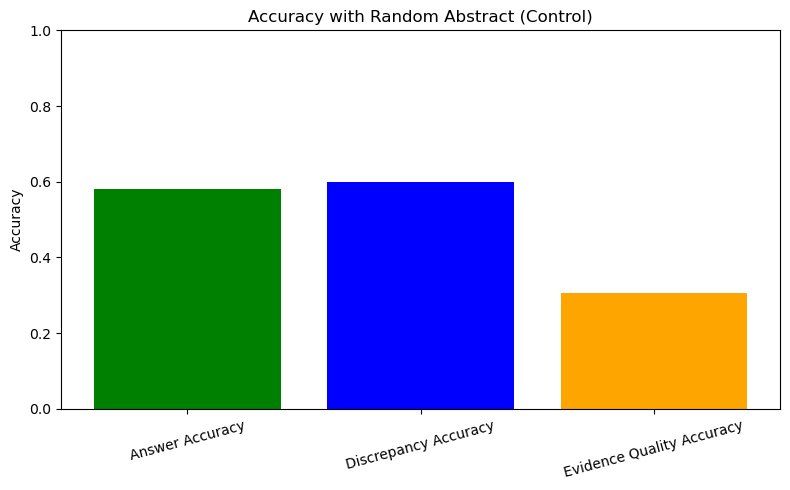

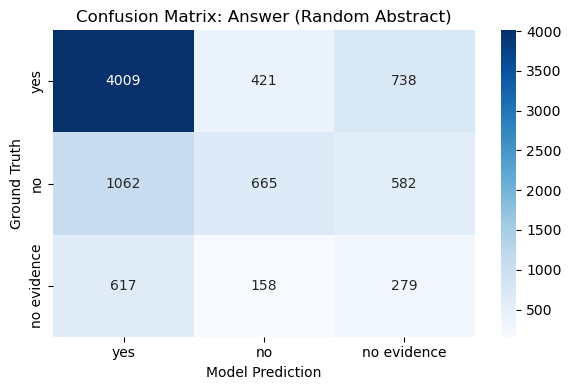

In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the random abstract result file
with open("rag_eval_results_with_random_abstract.json", "r") as f:
    with_random_abstract = json.load(f)

# Convert to DataFrame
df_random = pd.DataFrame.from_dict(with_random_abstract, orient="index")

# Normalize fields
df_random["model_answer"] = df_random["model_answer"].str.lower().str.strip()
df_random["ground_truth_answer"] = df_random["ground_truth_answer"].str.lower().str.strip()
df_random["model_discrepancy"] = df_random["model_discrepancy"].str.lower().str.strip()
df_random["ground_truth_discrepancy"] = df_random["ground_truth_discrepancy"].str.lower().str.strip()
df_random["model_evidence-quality"] = df_random["model_evidence-quality"].str.lower().str.strip()
df_random["ground_truth_evidence-quality"] = df_random["ground_truth_evidence-quality"].str.lower().str.strip()

# Compute accuracy flags
df_random["answer_correct"] = df_random["model_answer"] == df_random["ground_truth_answer"]
df_random["discrepancy_correct"] = df_random["model_discrepancy"] == df_random["ground_truth_discrepancy"]
df_random["evidence_quality_correct"] = df_random["model_evidence-quality"] == df_random["ground_truth_evidence-quality"]

# Summary DataFrame
summary_df = pd.DataFrame({
    "Metric": ["Answer Accuracy", "Discrepancy Accuracy", "Evidence Quality Accuracy"],
    "Accuracy": [
        df_random["answer_correct"].mean(),
        df_random["discrepancy_correct"].mean(),
        df_random["evidence_quality_correct"].mean()
    ],
    "Total Count": len(df_random)
})

# Print summary
print(summary_df.to_string(index=False))

# Plot
plt.figure(figsize=(8, 5))
plt.bar(summary_df["Metric"], summary_df["Accuracy"], color=["green", "blue", "orange"])
plt.ylim(0, 1)
plt.title("Accuracy with Random Abstract (Control)")
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()



import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define label order
labels = ["yes", "no", "no evidence"]

# Generate confusion matrix
cm = confusion_matrix(
    df_random["ground_truth_answer"],
    df_random["model_answer"],
    labels=labels
)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: Answer (Random Abstract)")
plt.xlabel("Model Prediction")
plt.ylabel("Ground Truth")
plt.tight_layout()
plt.show()


In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load original baseline (no context) results
with open("test_4o_mini_on_4o_questions_with_predictions.json", "r") as f:
    baseline_data = json.load(f)

# Load random abstract results
with open("rag_eval_results_with_random_abstract.json", "r") as f:
    random_data = json.load(f)

# Build DataFrame with matching DOIs
def build_df(source, label):
    records = []
    for qid, item in source.items():
        doi = item.get("doi", "").strip().lower()
        records.append({
            "qid": qid,
            "doi": doi,
            "model_answer": item.get("model_answer", "").strip().lower(),
            "ground_truth_answer": item.get("ground_truth_answer", "").strip().lower(),
            "condition": label
        })
    return pd.DataFrame(records)

df_no_random = build_df(baseline_data, "No Context")
df_rand = build_df(random_data, "Random Abstract")

# Align by DOI
common_dois = set(df_no_random["doi"]) & set(df_rand["doi"])
df_no_random = df_no_random[df_no_random["doi"].isin(common_dois)]
df_rand = df_rand[df_rand["doi"].isin(common_dois)]

# Merge on DOI
df_merged = pd.merge(
    df_no_random[["doi", "model_answer", "ground_truth_answer"]],
    df_rand[["doi", "model_answer"]],
    on="doi",
    suffixes=("_no", "_rand")
)

# Flag correctness
df_merged["correct_no"] = df_merged["model_answer_no"] == df_merged["ground_truth_answer"]
df_merged["correct_rand"] = df_merged["model_answer_rand"] == df_merged["ground_truth_answer"]

# Count sets
df_incorrect = df_merged[df_merged["correct_no"] == False]
df_correct = df_merged[df_merged["correct_no"] == True]
n_incorrect = len(df_incorrect)
n_correct = len(df_correct)
n_total = len(df_merged)

# Accuracy after using random abstract
acc_after_incorrect = df_incorrect["correct_rand"].mean()
acc_after_correct = df_correct["correct_rand"].mean()
acc_after_total = df_merged["correct_rand"].mean()


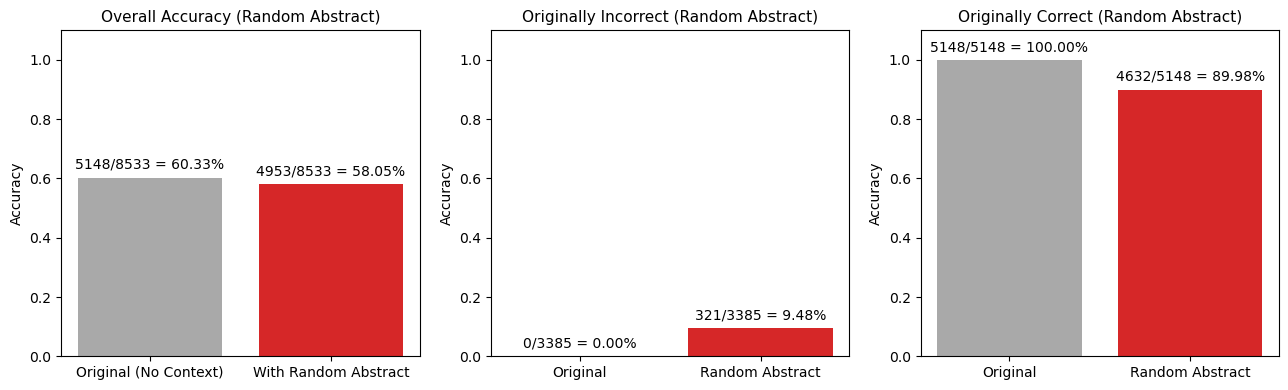

In [6]:
import matplotlib.pyplot as plt

def plot_pair(ax, title, labels, heights, counts, totals, colors):
    bars = ax.bar(labels, heights, color=colors)
    for bar, count, total, acc in zip(bars, counts, totals, heights):
        label = f"{count}/{total} = {acc:.2%}"
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                label, ha='center', va='bottom', fontsize=10)
    ax.set_ylim(0, 1.1)
    ax.set_title(title, fontsize=11)
    ax.set_ylabel("Accuracy")
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=0)


before_color = "#A9A9A9"   # gray
after_color = "#d62728"    # red
colors = [before_color, after_color]


fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# 1. Overall
plot_pair(
    ax=axes[0],
    title="Overall Accuracy (Random Abstract)",
    labels=["Original (No Context)", "With Random Abstract"],
    heights=[
        df_merged["correct_no"].mean(),
        df_merged["correct_rand"].mean()
    ],
    counts=[
        df_merged["correct_no"].sum(),
        df_merged["correct_rand"].sum()
    ],
    totals=[n_total, n_total],
    colors=colors
)

# 2. Originally Incorrect
plot_pair(
    ax=axes[1],
    title="Originally Incorrect (Random Abstract)",
    labels=["Original", "Random Abstract"],
    heights=[0, acc_after_incorrect],
    counts=[0, df_incorrect["correct_rand"].sum()],
    totals=[n_incorrect, n_incorrect],
    colors=colors
)

# 3. Originally Correct
plot_pair(
    ax=axes[2],
    title="Originally Correct (Random Abstract)",
    labels=["Original", "Random Abstract"],
    heights=[1, acc_after_correct],
    counts=[n_correct, df_correct["correct_rand"].sum()],
    totals=[n_correct, n_correct],
    colors=colors
)


plt.tight_layout()
# plt.savefig("random-abstracts-row.png", dpi=300)
plt.show()


### pubmed search results

Filtered out 2487 questions with no PubMed results.

                   Metric  Accuracy  Total Count
          Answer Accuracy  0.799041         6046
     Discrepancy Accuracy  0.638439         6046
Evidence Quality Accuracy  0.598743         6046


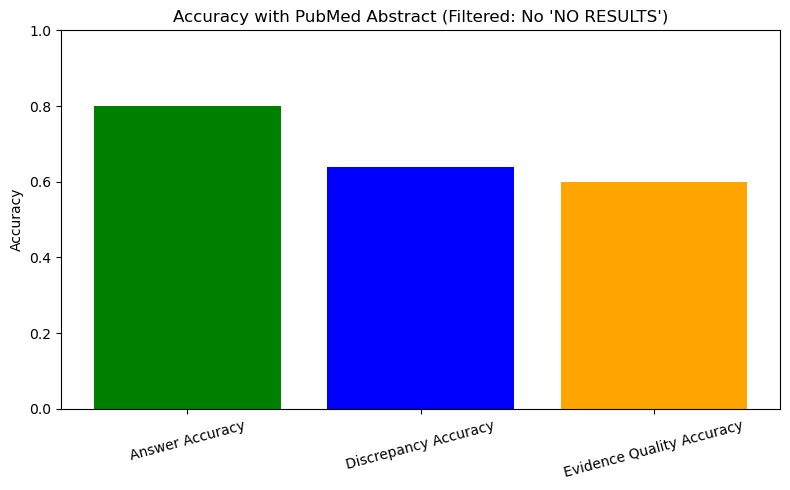

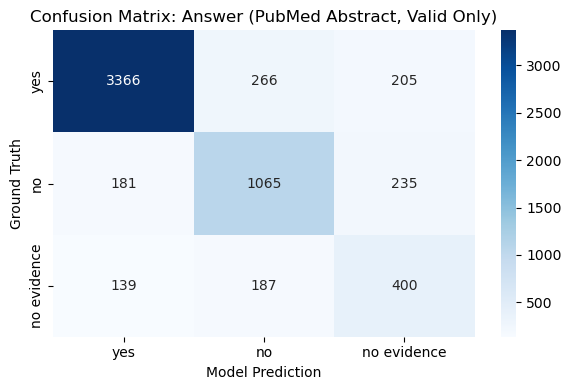

In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load model predictions
with open("rag_eval_results_with_pubmed_search.json", "r") as f:
    with_pubmed_abstract = json.load(f)

# Load pubmed context source to identify empty contexts
with open("pubmed_context_dataset.json", "r") as f:
    pubmed_context_raw = json.load(f)

# Filter: keep only entries with actual pubmed context
valid_qids = {
    qid for qid, entry in pubmed_context_raw.items()
    if entry["pubmed_context"].strip().upper() != "NO PUBMED RESULTS FOUND"
}
filtered_pubmed_data = {
    qid: item for qid, item in with_pubmed_abstract.items() if qid in valid_qids
}

# Convert to DataFrame
df_pubmed = pd.DataFrame.from_dict(filtered_pubmed_data, orient="index")

# Normalize fields
df_pubmed["model_answer"] = df_pubmed["model_answer"].str.lower().str.strip()
df_pubmed["ground_truth_answer"] = df_pubmed["ground_truth_answer"].str.lower().str.strip()
df_pubmed["model_discrepancy"] = df_pubmed["model_discrepancy"].str.lower().str.strip()
df_pubmed["ground_truth_discrepancy"] = df_pubmed["ground_truth_discrepancy"].str.lower().str.strip()
df_pubmed["model_evidence-quality"] = df_pubmed["model_evidence-quality"].str.lower().str.strip()
df_pubmed["ground_truth_evidence-quality"] = df_pubmed["ground_truth_evidence-quality"].str.lower().str.strip()

# Compute accuracy flags
df_pubmed["answer_correct"] = df_pubmed["model_answer"] == df_pubmed["ground_truth_answer"]
df_pubmed["discrepancy_correct"] = df_pubmed["model_discrepancy"] == df_pubmed["ground_truth_discrepancy"]
df_pubmed["evidence_quality_correct"] = df_pubmed["model_evidence-quality"] == df_pubmed["ground_truth_evidence-quality"]

# Summary DataFrame
summary_df_pubmed = pd.DataFrame({
    "Metric": ["Answer Accuracy", "Discrepancy Accuracy", "Evidence Quality Accuracy"],
    "Accuracy": [
        df_pubmed["answer_correct"].mean(),
        df_pubmed["discrepancy_correct"].mean(),
        df_pubmed["evidence_quality_correct"].mean()
    ],
    "Total Count": len(df_pubmed)
})

print(f"Filtered out {len(with_pubmed_abstract) - len(df_pubmed)} questions with no PubMed results.\n")

# Print summary
print(summary_df_pubmed.to_string(index=False))

# Accuracy bar plot
plt.figure(figsize=(8, 5))
plt.bar(summary_df_pubmed["Metric"], summary_df_pubmed["Accuracy"], color=["green", "blue", "orange"])
plt.ylim(0, 1)
plt.title("Accuracy with PubMed Abstract (Filtered: No 'NO RESULTS')")
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Confusion matrix (answer only)
labels = ["yes", "no", "no evidence"]
cm_pubmed = confusion_matrix(
    df_pubmed["ground_truth_answer"],
    df_pubmed["model_answer"],
    labels=labels
)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_pubmed, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: Answer (PubMed Abstract, Valid Only)")
plt.xlabel("Model Prediction")
plt.ylabel("Ground Truth")
plt.tight_layout()
plt.show()


In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load original baseline (no context)
with open("test_4o_mini_on_4o_questions_with_predictions.json", "r") as f:
    baseline_data = json.load(f)

# Load pubmed predictions
with open("rag_eval_results_with_pubmed_search.json", "r") as f:
    pubmed_pred = json.load(f)

# Load original pubmed context (to filter out empty context)
with open("pubmed_context_dataset.json", "r") as f:
    pubmed_context = json.load(f)

# Filter only those with valid pubmed context
valid_qids = {
    qid for qid, entry in pubmed_context.items()
    if entry["pubmed_context"].strip().upper() != "NO PUBMED RESULTS FOUND"
}
pubmed_pred = {qid: item for qid, item in pubmed_pred.items() if qid in valid_qids}
baseline_data = {qid: item for qid, item in baseline_data.items() if qid in valid_qids}

# Build DataFrame
def build_df(source, label):
    records = []
    for qid, item in source.items():
        doi = item.get("doi", "").strip().lower()
        records.append({
            "qid": qid,
            "doi": doi,
            "model_answer": item.get("model_answer", "").strip().lower(),
            "ground_truth_answer": item.get("ground_truth_answer", "").strip().lower(),
            "condition": label
        })
    return pd.DataFrame(records)

df_no_pub = build_df(baseline_data, "No Context")
df_pub = build_df(pubmed_pred, "PubMed Search")

# Align by DOI
common_dois = set(df_no_pub["doi"]) & set(df_pub["doi"])
df_no_pub = df_no_pub[df_no_pub["doi"].isin(common_dois)]
df_pub = df_pub[df_pub["doi"].isin(common_dois)]

# Merge
df_merge = pd.merge(
    df_no_pub[["doi", "model_answer", "ground_truth_answer"]],
    df_pub[["doi", "model_answer"]],
    on="doi",
    suffixes=("_no", "_pub")
)

# Compute correctness
df_merge["correct_no"] = df_merge["model_answer_no"] == df_merge["ground_truth_answer"]
df_merge["correct_pub"] = df_merge["model_answer_pub"] == df_merge["ground_truth_answer"]

# Split
df_incorrect = df_merge[df_merge["correct_no"] == False]
df_correct = df_merge[df_merge["correct_no"] == True]
n_incorrect = len(df_incorrect)
n_correct = len(df_correct)
n_total = len(df_merge)

# Accuracy stats
acc_after_incorrect = df_incorrect["correct_pub"].mean()
acc_after_correct = df_correct["correct_pub"].mean()
acc_after_total = df_merge["correct_pub"].mean()



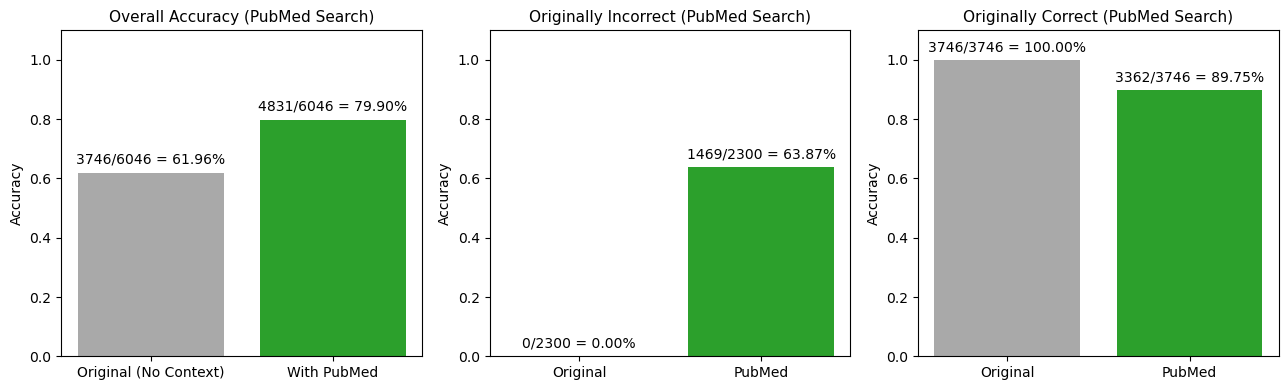

In [9]:
import matplotlib.pyplot as plt

def plot_pair(ax, title, labels, heights, counts, totals, colors):
    bars = ax.bar(labels, heights, color=colors)
    for bar, count, total, acc in zip(bars, counts, totals, heights):
        label = f"{count}/{total} = {acc:.2%}"
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                label, ha='center', va='bottom', fontsize=10)
    ax.set_ylim(0, 1.1)
    ax.set_title(title, fontsize=11)
    ax.set_ylabel("Accuracy")
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)


before_color = "#A9A9A9"
after_color = "#2ca02c"
colors = [before_color, after_color]


fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# 1. Overall
plot_pair(
    ax=axes[0],
    title="Overall Accuracy (PubMed Search)",
    labels=["Original (No Context)", "With PubMed"],
    heights=[
        df_merge["correct_no"].mean(),
        df_merge["correct_pub"].mean()
    ],
    counts=[
        df_merge["correct_no"].sum(),
        df_merge["correct_pub"].sum()
    ],
    totals=[n_total, n_total],
    colors=colors
)

# 2. Originally Incorrect
plot_pair(
    ax=axes[1],
    title="Originally Incorrect (PubMed Search)",
    labels=["Original", "PubMed"],
    heights=[0, acc_after_incorrect],
    counts=[0, df_incorrect["correct_pub"].sum()],
    totals=[n_incorrect, n_incorrect],
    colors=colors
)

# 3. Originally Correct
plot_pair(
    ax=axes[2],
    title="Originally Correct (PubMed Search)",
    labels=["Original", "PubMed"],
    heights=[1, acc_after_correct],
    counts=[n_correct, df_correct["correct_pub"].sum()],
    totals=[n_correct, n_correct],
    colors=colors
)

plt.tight_layout()
# plt.savefig("pubmed-abstracts-row.png", dpi=300)
plt.show()


### Comparison

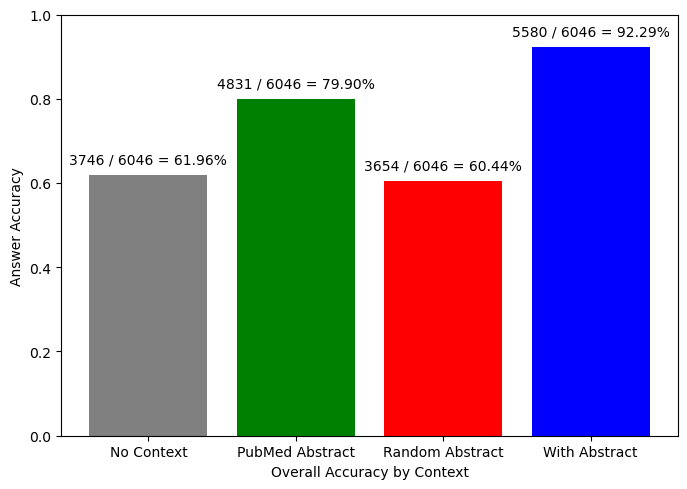

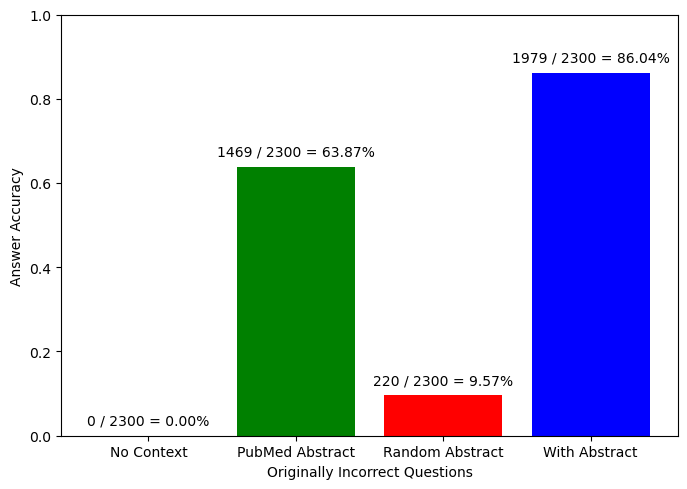

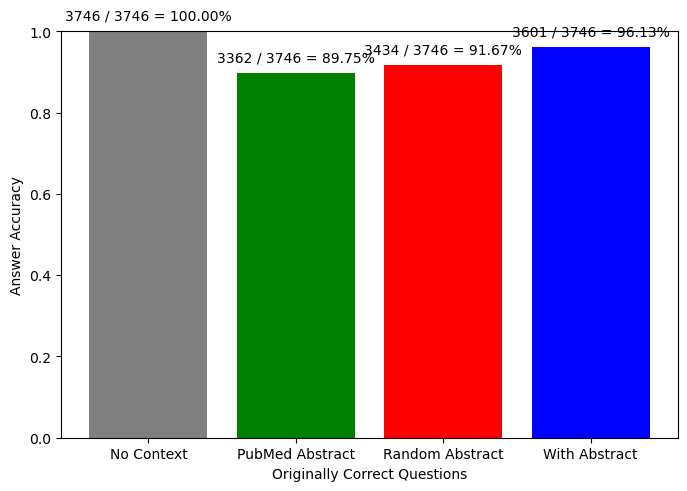

In [10]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load all result sets
with open("test_4o_mini_on_4o_questions_with_predictions.json", "r") as f:
    no_context = json.load(f)

with open("rag_eval_results_with_abstract.json", "r") as f:
    with_abstract = json.load(f)

with open("rag_eval_results_with_random_abstract.json", "r") as f:
    with_random = json.load(f)

with open("rag_eval_results_with_pubmed_search.json", "r") as f:
    with_pubmed = json.load(f)

with open("pubmed_context_dataset.json", "r") as f:
    pubmed_contexts = json.load(f)

# Filter: keep only pubmed entries with actual results
valid_pubmed_qids = {
    qid for qid, entry in pubmed_contexts.items()
    if entry["pubmed_context"].strip().upper() != "NO PUBMED RESULTS FOUND"
}
with_pubmed = {qid: item for qid, item in with_pubmed.items() if qid in valid_pubmed_qids}
no_context = {qid: item for qid, item in no_context.items() if qid in valid_pubmed_qids}

# Helper to convert dict to df
def build_df(source, label):
    records = []
    for qid, item in source.items():
        doi = item.get("doi", "").strip().lower()
        records.append({
            "qid": qid,
            "doi": doi,
            "model_answer": item.get("model_answer", "").strip().lower(),
            "ground_truth_answer": item.get("ground_truth_answer", "").strip().lower(),
            "condition": label
        })
    return pd.DataFrame(records)

# Build individual DataFrames
df_no = build_df(no_context, "No Context")
df_abs = build_df(with_abstract, "With Abstract")
df_rand = build_df(with_random, "Random Abstract")
df_pub = build_df(with_pubmed, "PubMed Abstract")

# Match only common DOIs
common_dois = set(df_no["doi"]) & set(df_abs["doi"]) & set(df_rand["doi"]) & set(df_pub["doi"])
df_no = df_no[df_no["doi"].isin(common_dois)]
df_abs = df_abs[df_abs["doi"].isin(common_dois)]
df_rand = df_rand[df_rand["doi"].isin(common_dois)]
df_pub = df_pub[df_pub["doi"].isin(common_dois)]

# Merge everything
df_all = pd.concat([df_no, df_abs, df_rand, df_pub], ignore_index=True)
df_all["correct"] = df_all["model_answer"] == df_all["ground_truth_answer"]

# --- Plotting helper ---
def plot_summary(df, title):
    summary = df.groupby("condition").agg(
        accuracy=("correct", "mean"),
        correct=("correct", "sum"),
        total=("correct", "count")
    ).reset_index()

    summary["label"] = summary.apply(
        lambda row: f"{int(row.correct)} / {int(row.total)} = {row.accuracy:.2%}", axis=1
    )

    plt.figure(figsize=(7, 5))
    bars = plt.bar(summary["condition"], summary["accuracy"], color=["gray", "green", "red", "blue"])
    plt.ylim(0, 1)
    plt.ylabel("Answer Accuracy")
    plt.xlabel(title)
    plt.title("")
    for bar, label in zip(bars, summary["label"]):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.02, label,
                 ha='center', va='bottom', fontsize=10)
    plt.subplots_adjust(bottom=0.25)
    plt.tight_layout()
    plt.show()

# --- 1. Overall ---
plot_summary(df_all, "Overall Accuracy by Context")

# --- 2. Originally Incorrect ---
original_no = df_no.copy()
original_no["correct"] = original_no["model_answer"] == original_no["ground_truth_answer"]
wrong_dois = original_no[original_no["correct"] == False]["doi"]

df_incorrect = df_all[df_all["doi"].isin(wrong_dois)]
plot_summary(df_incorrect, "Originally Incorrect Questions")

# --- 3. Originally Correct ---
correct_dois = original_no[original_no["correct"] == True]["doi"]
df_correct = df_all[df_all["doi"].isin(correct_dois)]
plot_summary(df_correct, "Originally Correct Questions")


a validation of how similarity between Qs and searching results affect prediction accuracy

In [11]:
import json
import pandas as pd

MAX_SAMPLES = 1000
MAX_ABSTRACT_CHARS = 2000

with open("rag_eval_results_with_pubmed_search.json", "r") as f:
    eval_data = json.load(f)

with open("pubmed_context_dataset.json", "r") as f:
    context_data = json.load(f)

records = []
for qid, item in eval_data.items():
    if len(records) >= MAX_SAMPLES:
        break
    abstract = context_data.get(qid, {}).get("pubmed_context", "")
    if abstract.strip().upper() == "NO PUBMED RESULTS FOUND":
        continue
    records.append({
        "qid": qid,
        "question": item["question"],
        "abstract": abstract[:MAX_ABSTRACT_CHARS],
        "model_answer": item["model_answer"].strip().lower(),
        "ground_truth_answer": item["ground_truth_answer"].strip().lower()
    })

df_pubmed = pd.DataFrame(records)
df_pubmed["correct"] = df_pubmed["model_answer"] == df_pubmed["ground_truth_answer"]
df_pubmed.to_csv("pubmed_eval_for_embedding.csv", index=False)


In [12]:
import openai
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

openai.api_key = "OPENAI_API_KEY_REDACTED"  # Replace with your API key

df_pubmed = pd.read_csv("pubmed_eval_for_embedding.csv")

def get_embedding(text, model="text-embedding-3-large"):
    return openai.embeddings.create(input=[text], model=model).data[0].embedding

question_embeddings = []
abstract_embeddings = []

for _, row in tqdm(df_pubmed.iterrows(), total=len(df_pubmed), desc="Embedding"):
    question_embeddings.append(get_embedding(row["question"]))
    abstract_embeddings.append(get_embedding(row["abstract"]))

df_pubmed["question_embedding"] = question_embeddings
df_pubmed["abstract_embedding"] = abstract_embeddings

df_pubmed["similarity"] = [
    cosine_similarity([q], [a])[0][0]
    for q, a in zip(question_embeddings, abstract_embeddings)
]

df_pubmed.to_csv("pubmed_eval_1000_with_similarity.csv", index=False)


Embedding: 100%|████████████████████████████| 1000/1000 [10:51<00:00,  1.53it/s]


Optimization terminated successfully.
         Current function value: 0.462814
         Iterations 6


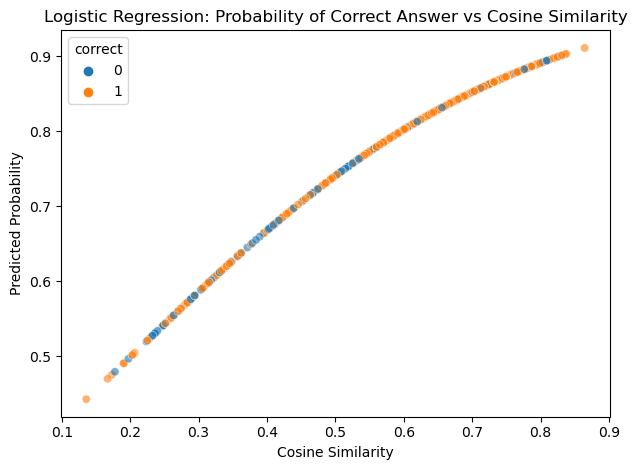

                           Logit Regression Results                           
Dep. Variable:                correct   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Fri, 13 Jun 2025   Pseudo R-squ.:                 0.04815
Time:                        16:37:31   Log-Likelihood:                -462.81
converged:                       True   LL-Null:                       -486.22
Covariance Type:            nonrobust   LLR p-value:                 7.787e-12
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7049      0.313     -2.254      0.024      -1.318      -0.092
similarity     3.5114      0.508      6.915      0.000       2.516       4.507


In [13]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# Load similarity and correctness data
df_pubmed = pd.read_csv("pubmed_eval_1000_with_similarity.csv")

# Filter valid rows
df_pubmed = df_pubmed.dropna(subset=["similarity", "correct"])
df_pubmed["correct"] = df_pubmed["correct"].astype(int)

# Define independent and dependent variables
X = sm.add_constant(df_pubmed["similarity"])
y = df_pubmed["correct"]

# Fit logistic regression model
logit_model = sm.Logit(y, X).fit()

# Add predicted probabilities to DataFrame
df_pubmed["pred_prob"] = logit_model.predict(X)

# Plot predicted probability vs. similarity
sns.scatterplot(data=df_pubmed, x="similarity", y="pred_prob", hue="correct", alpha=0.6)
plt.title("Logistic Regression: Probability of Correct Answer vs Cosine Similarity")
plt.xlabel("Cosine Similarity")
plt.ylabel("Predicted Probability")
plt.tight_layout()
plt.show()

# Print regression summary
print(logit_model.summary())
